In [1]:
import copy
import pathlib

import pandas as pd
from preprocessing.pipeline import (
    combine_data_NYPD,
    get_preprocessed_data,
    preprocess_311,
    process_crime_data,
    query_data,
)
from preprocessing.weather_parse import weather_parse


In [2]:
year = 2017
preprocessed_dir = pathlib.Path(f"../data/combined/year={year}")

try:
    df = pd.read_parquet(
        preprocessed_dir,
        )
    assert len(df) != 0
except AssertionError:
    df = get_preprocessed_data(
        start_date=year,
        end_date=year+1,
        sectors=False,
        opened_created_add=['borough', 'precinct', 'complaint_type'],
    ).convert_dtypes(dtype_backend='pyarrow')
    df.to_parquet(preprocessed_dir)
except FileNotFoundError:
    preprocessed_dir.mkdir()
    df = get_preprocessed_data(
        start_date=year,
        end_date=year+1,
        sectors=False,
        opened_created_add=['borough', 'precinct', 'complaint_type'],
    ).convert_dtypes(dtype_backend='pyarrow')

    df.to_parquet(preprocessed_dir)
except ValueError:
    boroughs = []
    for file_path in preprocessed_dir.glob('*'):

        if file_path.is_dir():
            try:
                boroughs.append(pd.read_parquet(file_path))
                # print(df)
            except Exception:
                print(file_path)

    df = pd.concat(boroughs)
df

,borough,precinct,complaint_type,created_H,closed_H,created_date,closed_date,agency,descriptor,status,...,precip_period_hrs,precip_accumulation_mm,direction_deg,speed_mps,dew_temperature_c,year,date_H,FELONY,MISDEMEANOR,VIOLATION
0,BRONX,40.0,Noise - Residential,2017-01-01 00:00:00,2017-01-01 09:00:00,2017-01-01 00:47:15,2017-01-01 09:22:44,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,18,3
1,BRONX,43.0,Blocked Driveway,2017-01-01 00:00:00,2017-01-01 14:00:00,2017-01-01 00:48:20,2017-01-01 14:12:14,NYPD,No Access,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
2,BRONX,43.0,Drug Activity,2017-01-01 00:00:00,2017-01-01 06:00:00,2017-01-01 00:19:10,2017-01-01 06:07:03,NYPD,Use Indoor,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
3,BRONX,43.0,Noise - Residential,2017-01-01 00:00:00,2017-01-01 05:00:00,2017-01-01 00:47:44,2017-01-01 05:46:55,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
4,BRONX,44.0,Blocked Driveway,2017-01-01 00:00:00,2017-01-01 09:00:00,2017-01-01 00:26:29,2017-01-01 09:41:39,NYPD,No Access,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,20,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489182,BROOKLYN,72.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:14:44,2018-12-31 23:31:57,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489183,MANHATTAN,19.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:39:13,2018-12-31 23:52:08,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489184,MANHATTAN,25.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:36:36,2018-12-31 23:51:07,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489185,MANHATTAN,34.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:11:23,2018-12-31 23:15:41,NYPD,Banging/Pounding,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0


In [3]:
df["resolution_class"].value_counts()

resolution_class
resolved before police    736174
resolved by police        591522
resolution unknown         86057
failed to respond          75396
Name: count, dtype: int64[pyarrow]

In [4]:
df.dtypes

borough                                  string[pyarrow]
precinct                                 string[pyarrow]
complaint_type                           string[pyarrow]
created_H                         timestamp[ns][pyarrow]
closed_H                          timestamp[ns][pyarrow]
created_date                      timestamp[ns][pyarrow]
closed_date                       timestamp[ns][pyarrow]
agency                                   string[pyarrow]
descriptor                               string[pyarrow]
status                                   string[pyarrow]
resolution_description                   string[pyarrow]
resolution_action_updated_date    timestamp[ns][pyarrow]
due_date                          timestamp[ns][pyarrow]
latitude                                 double[pyarrow]
longitude                                double[pyarrow]
hours_to_complete                        double[pyarrow]
created                                   int64[pyarrow]
created_bo                     

In [5]:
import datetime
import heapq
import json
import multiprocessing as mp
import pathlib
from dataclasses import dataclass, field
from typing import Iterable

import joblib
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from matplotlib import pyplot as plt
from preprocessing.pre_survival import prep_data_for_surv_analysis
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, train_test_split
from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
)
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw, cumulative_dynamic_auc
from sksurv.util import Surv
from statsmodels.duration.hazard_regression import PHReg, PHRegResults
from tqdm import tqdm

In [6]:
## HYPERPARAMETERS ##
from typing import List


save_name = input(
   "Input a name for this model or leave blank to use a hash of the model results"
)

root_save_dir: pathlib.Path = pathlib.Path("../models/survival_forest/")


@dataclass
class RSFParams:
   keep_cols: List = field(default_factory=lambda: [])
   add_datetime_cols: bool = True
   year:int = year
   seed: int = 14
   strata: list = field(default_factory=lambda: ["borough"])
   target_col: str = "hours_to_complete"
   status_col: str = "resolution_class"
   datetime_col: str = "created_H"
   save_name: str = save_name
   max_depth: int = 4
   cpu_prop: float = 0.5
   remove_cols: set = field(
      default_factory=lambda: {
         "descriptor",
         "resolution_description",
         "resolution_action_updated_date",
         "incident_zip",
         "city",
         "bbl",
         "status",
         "closed_H",
         "created_date",
         "closed_date",
         "sector",
         "due_date",
         "created",
         "date_H",
         "precinct",
         # 'created',
         # 'created_bo',
         # 'created_ag',
         # 'created_co',
         # 'created_bo_ag',
         # 'open',
         # 'open_bo',
         # 'open_ag',
         # 'open_co',
         # 'open_bo_ag',
         # 'open_bo_co',
         "precip_period_hrs",
         "precip_accumulation_mm",
         "direction_deg",
         "agency",
         'latitude',
         'longitude',
         # 'created_bo_co',
         # 'temperature_c',
         # 'speed_mps',
         # 'dew_temperature_c',
      }
   )
   ohe: bool = True


hyper = RSFParams()

In [7]:
class RSFHyperEncoder(json.JSONEncoder):
    def default(self, o):
        o_dict = o.__dict__
        for k in o_dict.keys():
            v = o_dict[k]
            if isinstance(v, str):
                o_dict[k] = v
            elif isinstance(v, Iterable):
                o_dict[k] = list(v)
        return o_dict

class DefaultDecoder:
    def __init__(self, cls):
        self.cls = cls
        self.annotations = getattr(cls, '__annotations__', {})

    def __call__(self, data):
        for key, value_type in self.annotations.items():
            if key not in data:
                continue
            value = data[key]
            try:
                if not isinstance(value, value_type):
                    data[key] = value_type(value)
            except (TypeError, ValueError):
                raise TypeError(f"Value for '{key}' must be of type '{value_type.__name__}'")
        return self.cls(data)

rsf_decoder = DefaultDecoder(RSFParams)

In [8]:
assert 0 < hyper.cpu_prop <= 1
n_jobs = int(mp.cpu_count() * hyper.cpu_prop)
try:
    if not save_name:
        raise FileNotFoundError
    save_path = root_save_dir / f"{save_name}"

    with (save_path / "hyper.json").open("r") as f:
        hyper = json.load(f, object_hook=rsf_decoder)
    if hyper.ohe:
        ohe_obj = joblib.load(save_path / "ohe.pickle")
    else:
        ohe_obj = None

    rsf = joblib.load(root_save_dir / f"{save_name}" / "rsf.pickle")
    scaler_obj = joblib.load(root_save_dir / f"{save_name}" / "scaler.pickle")
    X_train, X_test, y_train, y_test, ohe, scaler_obj = prep_data_for_surv_analysis(
        df, ohe_obj=ohe_obj, scaler_obj=scaler_obj, **hyper.__dict__
    )

except FileNotFoundError:
    (root_save_dir / f"{save_name}").mkdir(exist_ok=True)

    X_train, X_test, y_train, y_test, ohe, scaler_obj = prep_data_for_surv_analysis(
        df, **hyper.__dict__
    )

    rsf = RandomSurvivalForest(
        max_depth=hyper.max_depth,
        min_samples_leaf=50,
        n_jobs=n_jobs,
        random_state=hyper.seed,
        verbose=2
    )
    rsf.fit(X_train, y_train)
    if not save_name:
        save_name = datetime.datetime.now().strftime(r"%d%m%Y_%H%M")
    save_path = root_save_dir / f"{save_name}"
    joblib.dump(rsf, save_path / "rsf.pickle")
    joblib.dump(scaler_obj, save_path / "scaler.pickle")
    if ohe:
        joblib.dump(ohe, save_path / "ohe.pickle")
    hyper.ohe = True if ohe else False
    hyper.keep_cols = list(X_train.columns)

    with (save_path / "hyper.json").open("x") as f:
        json.dump(hyper, f, cls=RSFHyperEncoder, indent=4)

Dropped borough    22
dtype: int64 entries from strata below threshold 50


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   25.3s


building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67

[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:  2.9min finished


In [9]:
surv = rsf.predict_survival_function(X_test[:2000], return_array=True)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    3.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   20.6s finished


In [11]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sklearn.model_selection import GridSearchCV
from lifelines import utils
from sksurv.metrics import cumulative_dynamic_auc, concordance_index_ipcw
import heapq
from tqdm import tqdm

subjects = list(range(X_test[:2000].shape[0]))
predictions = utils.qth_survival_times(0.5, surv[subjects]).T.squeeze()

In [20]:
gt = pd.Series([y[1] for y in y_test], name="Ground Truth")

0.25    0.0
0.50    0.0
0.75    0.0
Name: 0.5, dtype: float64

In [21]:
final_df = pd.concat([X_test[:2000].reset_index(), gt, predictions])
final_df

,index,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,...,open_bo_pr_co,temperature_c,speed_mps,dew_temperature_c,year,FELONY,MISDEMEANOR,VIOLATION,Ground Truth,0.5
0,200354.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.251484,0.420419,-0.002551,0.666504,0.0,-0.235931,-0.245047,-0.216458,NaN,NaN
1,78456.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.351680,-1.324891,-0.213539,-1.550346,0.0,-0.235931,-0.245047,-0.216458,NaN,NaN
2,79549.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.249498,0.190498,0.039647,-0.661609,0.0,-0.235931,-0.245047,-0.216458,NaN,NaN
3,549937.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.351680,1.528221,-0.213539,1.105880,0.0,-0.235931,-0.245047,-0.216458,NaN,NaN
4,722007.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.449891,-0.969558,0.215471,-1.440502,0.0,-0.235931,-0.245047,-0.216458,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73589,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
73590,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
73591,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
73592,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
import seaborn as sns
# Define a color palette for different complaint types
palette = sns.color_palette("husl", len(tst_sample['complaint_type'].unique()))

# Create a scatter plot with Seaborn
jg = sns.jointplot(data=X_test, x='hours_to_complete', y='pred_htc', hue='complaint_type', palette=palette, alpha=0.7)
ax = jg.ax_joint
# Show the plot
ax.set_ylim(-1, 20)
ax.set_xlim(ax.get_ylim())
plt.plot([-10,100],[-10,100], color='k')
fig = ax.get_figure()
fig.set_size_inches((20,12))
# ax.legend(bbox_to_anchor=[1,0.55])
ax.set_xlabel('True Time to Close Complaint (hours)')
ax.set_ylabel('Predicted Expected Time to Close Complaint (hours)')
ax.set_title('Predicted vs True Time to Close Complaint in Hours')

In [ ]:
for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in Hours")
plt.legend([])
plt.xlim((0,24))
plt.grid(True)

Error in callback <function flush_figures at 0x72eef68be050> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
y_train

array([( True, 4.49972222), ( True, 4.24583333), ( True, 4.28888889), ...,
       ( True, 4.11833333), ( True, 0.09583333), ( True, 0.67      )],
      dtype=[('event', '?'), ('time', '<f8')])

In [ ]:

times = np.percentile(df["hours_to_complete"], np.linspace(5, 81, 15))
print(times)

[0.30833333 0.55138889 0.78333333 1.01916667 1.26805556 1.53638889
 1.82861111 2.14666667 2.50277778 2.90444444 3.36527778 3.905
 4.54777778 5.335      6.33361111]


In [ ]:


heap = []
# def plot_cumulative_dynamic_auc(risk_score, label, ax, color=None, ):



for i, col in tqdm(enumerate(X_train.columns)):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, X_test[col], times)
    # ret = concordance_index_ipcw(y_train, y_test, X_test[col], tau=times[-1], )
    in_heap = [mean_auc, col, auc,
            #    ret
               ]
    heapq.heappush(heap, in_heap)
    # plot_cumulative_dynamic_auc(X_test[col], col, color=f"C{i}",ax=ax)

top_10 = heapq.nlargest(10, heap)

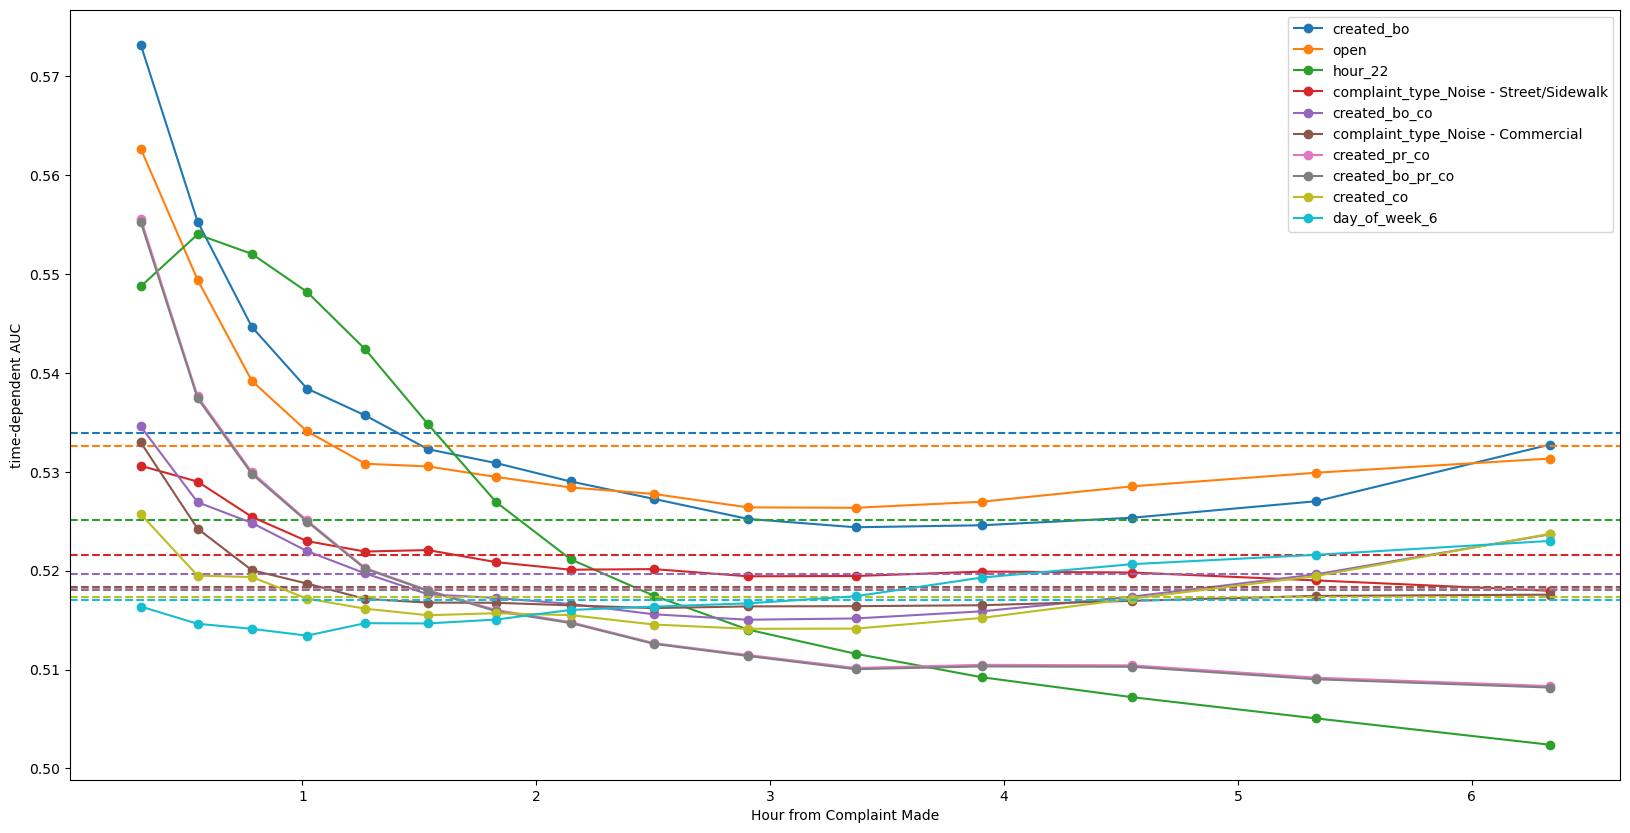

In [ ]:
top_10

fig, ax = plt.subplots()

fig.set_size_inches(20, 10)
for i, (mean_auc, col, auc) in enumerate(top_10):
    ax.plot(times, auc, marker="o", color=f"C{i}", label=col)
    ax.set_xlabel("Hour from Complaint Made")
    ax.set_ylabel("time-dependent AUC")
    ax.axhline(mean_auc, color=f"C{i}", linestyle="--")
    plt.legend()

In [ ]:
bottom_10 = heapq.nsmallest(10, heap)
bottom_10

[[0.3513422117196048,
  'open_bo_pr',
  array([0.31313978, 0.32002416, 0.32711117, 0.33981387, 0.34963323,
         0.35801261, 0.3617132 , 0.36510115, 0.36613465, 0.36498914,
         0.36404218, 0.36288589, 0.36030326, 0.35395815, 0.3445588 ])],
 [0.3515002788308468,
  'open_pr',
  array([0.31348254, 0.32026813, 0.32724187, 0.33988468, 0.34972519,
         0.35803465, 0.36179373, 0.3651897 , 0.36622038, 0.36511368,
         0.36420675, 0.36310815, 0.36052073, 0.35419614, 0.34484748])],
 [0.36699487002465603,
  'open_bo_pr_co',
  array([0.26586991, 0.28873815, 0.31089973, 0.33654145, 0.35628791,
         0.3708377 , 0.38018493, 0.38776454, 0.39177439, 0.39379578,
         0.39469947, 0.39652515, 0.39687246, 0.39375885, 0.38801097])],
 [0.3671605397286612,
  'open_pr_co',
  array([0.26636624, 0.28905455, 0.3111034 , 0.33668838, 0.35641547,
         0.37089449, 0.38029307, 0.38786972, 0.39186202, 0.3939044 ,
         0.3948396 , 0.39668297, 0.39702173, 0.39394844, 0.38822261])],
 [0.473

In [ ]:
times = np.arange(0, 24, 7)
cph_risk_scores = rsf.predict(X_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train[:10_000], y_test[:10_000], cph_risk_scores, times)

plt.plot(times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("Hour from Complaint Made")
plt.ylabel("time-dependent AUC")
plt.grid(True)

: 

In [ ]:
result = permutation_importance(rsf, X_test, y_test, n_repeats=5, random_state=hyper.seed, max_samples=0.01)

In [ ]:
imp_df = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

In [ ]:
imp_df.loc[(imp_df['importances_mean'] != 0)]

,importances_mean,importances_std
precinct_46.0,0.003509,0.008946
open_bo_pr,0.001754,0.041293
precinct_44.0,0.001754,0.027960
precinct_110.0,-0.003509,0.008946
open_bo_pr_co,-0.005263,0.025784
precinct_62.0,-0.005263,0.014253
longitude,-0.008772,0.060520
latitude,-0.008772,0.071047
precinct_34.0,-0.008772,0.049622
precinct_104.0,-0.021053,0.019693


In [36]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")


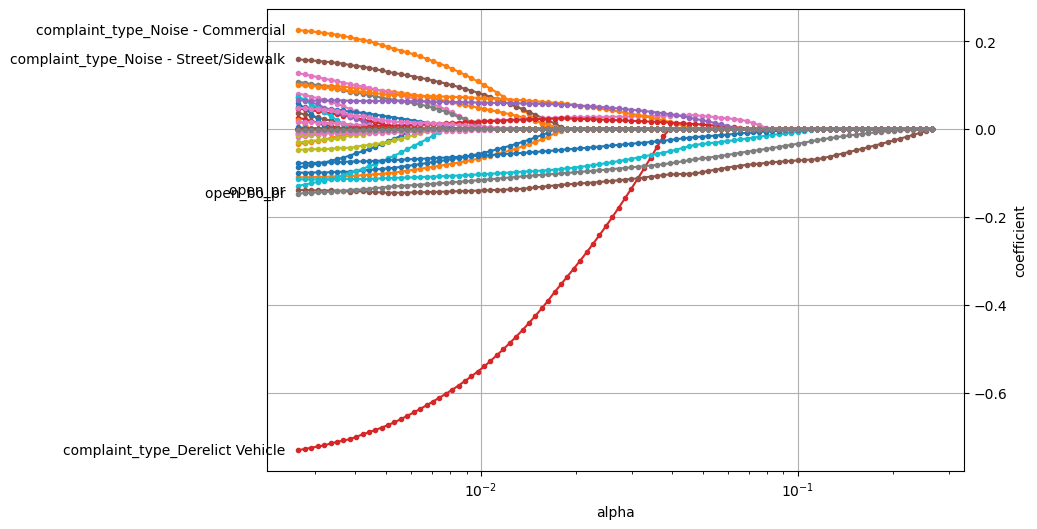

In [38]:


GridSearchCV(scoring=)
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(X_train, y_train)
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=X_train.columns, columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=5)

In [ ]:
times = np.arange(0, 24, 7)
cph_risk_scores = rsf.predict(X_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, times)

plt.plot(times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("Hour from Complaint Made")
plt.ylabel("time-dependent AUC")
plt.grid(True)